In [1]:
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import ensemble
from  sklearn import linear_model

import scipy.stats as stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor

from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style('white')
sns.set(rc={'figure.figsize':(12,7)})

In [2]:
df=pd.read_csv('Melbourne_housing_FULL.csv')

In [3]:
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

In [4]:
#Removing null values
df.dropna(inplace=True, axis=0)

In [5]:
df.isnull().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

In [6]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0
11,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,2.0,0.0,245.0,210.0,1910.0,Yarra City Council,-37.8024,144.9993,Northern Metropolitan,4019.0
14,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,1.0,2.0,256.0,107.0,1890.0,Yarra City Council,-37.8060,144.9954,Northern Metropolitan,4019.0


In [7]:
# Dropping unnecessary columns
df.drop(['Address', 'SellerG', 'Date'], inplace=True, axis=1)

This is a regression problem where we are trying to predict House prices based on various features.We also want to know some explanotory power of these features in determining the value of the houses.  

Here, we want to compare the Supervised learning model (Random Forest Regression, Gradient Boost regression) vs Unsupervised learning mdoel (MLP). What is the tradeoff of complexitiy and accuracy. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8887 entries, 2 to 34856
Data columns (total 18 columns):
Suburb           8887 non-null object
Rooms            8887 non-null int64
Type             8887 non-null object
Price            8887 non-null float64
Method           8887 non-null object
Distance         8887 non-null float64
Postcode         8887 non-null float64
Bedroom2         8887 non-null float64
Bathroom         8887 non-null float64
Car              8887 non-null float64
Landsize         8887 non-null float64
BuildingArea     8887 non-null float64
YearBuilt        8887 non-null float64
CouncilArea      8887 non-null object
Lattitude        8887 non-null float64
Longtitude       8887 non-null float64
Regionname       8887 non-null object
Propertycount    8887 non-null float64
dtypes: float64(12), int64(1), object(5)
memory usage: 1.3+ MB


In [9]:
# Grouping of small values into bigger group in Suburb feature
names=df.Suburb.value_counts()[df.Suburb.value_counts()<5].keys()
df['Suburb1'] = df['Suburb']
for name in names:
    df.loc[df['Suburb'].str.contains(name), 'Suburb1'] = 'Other'
    
# Grouping of small values into bigger group in Rooms feature
items=df.Rooms.value_counts()[df.Rooms.value_counts() <51].keys()
df['Rooms1'] = df['Rooms']
for item in items:
    df.loc[df['Rooms'] == item, 'Rooms1'] = 7
df.Rooms1.value_counts()
df.drop(['Rooms', 'Suburb'], axis=1, inplace=True)

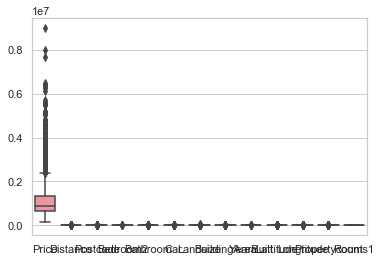

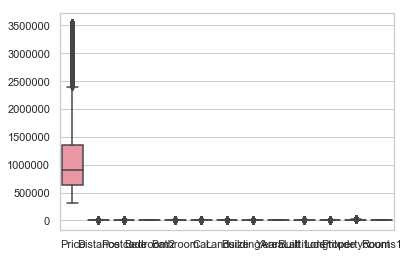

In [10]:
# Winsorising the outliers
# Box plot before winsorizing
sns.set_style("whitegrid")
g=sns.boxplot(data=df)
plt.show()

for columns in df:
    stats.mstats.winsorize(df[columns], inplace=True, limits = [0.01, 0.01])

# Box plot after winsorizing

sns.set_style("whitegrid")
g=sns.boxplot(data=df)
plt.show()

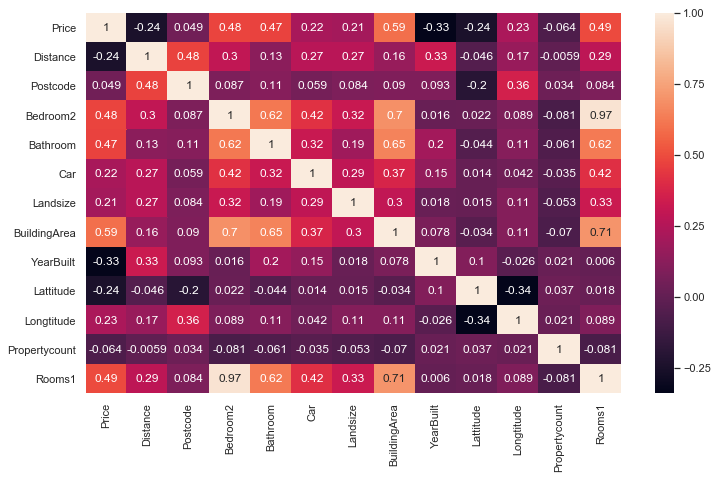

In [11]:
# Heat map
sns.set(rc={'figure.figsize':(12,7)})
sns.heatmap(df.corr(), annot=True)
plt.show()

From this correlation matrix we can see that number of bedrooms, bathrooms, building area, number of total rooms have a positive correlation and add value to the house price.

We need to confirm this with 'feature selection method'. 'recursive feature elimination method' which acutally runs the model and sees which features have great explanatory power for the variance in the price.

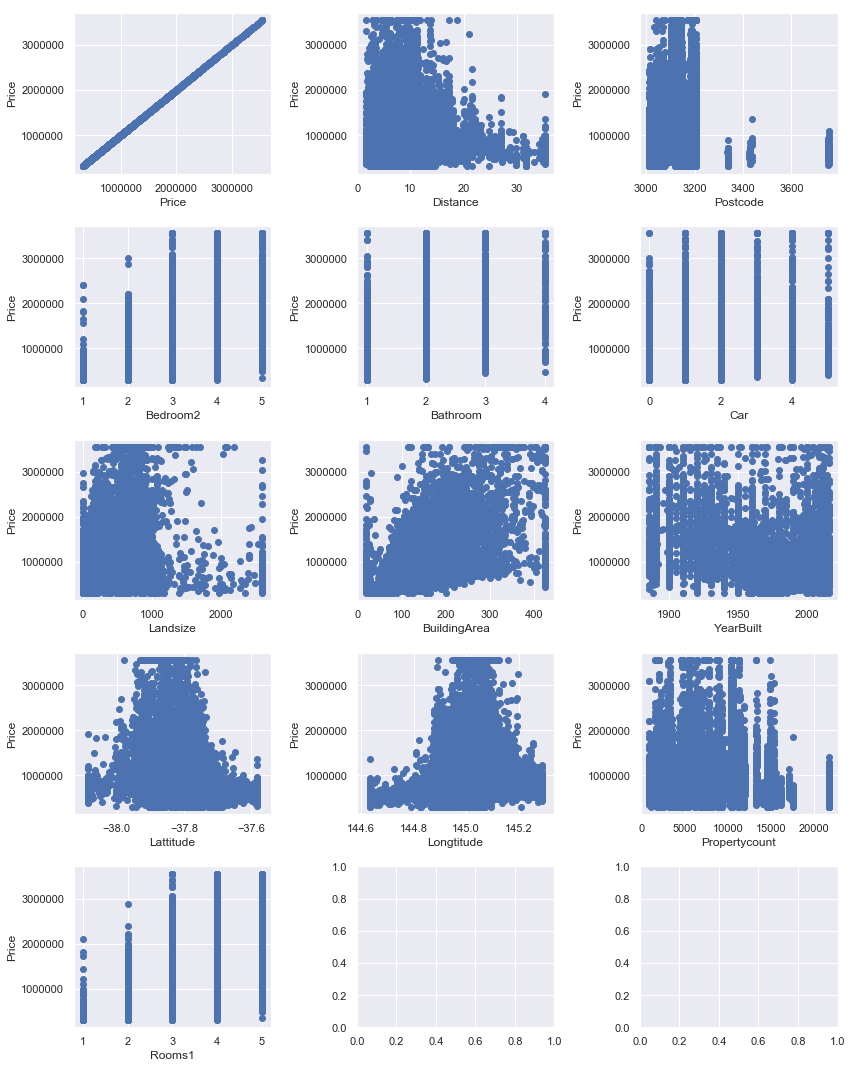

In [12]:
# Scatter plot to see the spread of the X variables in relation to outcome variable Y
num_datatype=df.select_dtypes(include=["number"])
x=y=0
fig, axes =plt.subplots(5,3)
fig.set_size_inches(12, 15)
for i in range(0, num_datatype.shape[1]):  
    axes[x,y].scatter(num_datatype.iloc[:, i], num_datatype['Price'])
    axes[x,y].set(xlabel=num_datatype.columns[i], ylabel='Price')
    plt.tight_layout()
    y+=1
    if (y==3):
        x+=1
        y=0
plt.show()

In [13]:
#Coverting the latitute and longitude into non-negative numbers
num_datatype['Lattitude']=abs(num_datatype['Lattitude'])
num_datatype['Longtitude']=abs(num_datatype['Longtitude'])

C:\Users\nagad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\nagad\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
Y=df['Price']
X=num_datatype.loc[:, ~(num_datatype.columns).isin(['Price'])]

In [15]:
#### Using SelectKBest selector to select valued features

In [16]:
Y=df['Price']
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)
# summarize scores and select the best 4 columns or features
np.set_printoptions(precision=3)
dic=dict()
for i, name in enumerate(X.columns):
    dic[name]=fit.scores_[i]
cols_selected=sorted(dic, key=dic.__getitem__, reverse=True)
print ('The most important columns are', cols_selected[0:4])

The most important columns are ['Propertycount', 'Landsize', 'BuildingArea', 'Distance']


In [17]:
#### Using Recurssive Feature Elimination

In [18]:
regr=linear_model.Lasso(alpha=0.001,max_iter=2000).fit(X,Y)
rfe = RFE(regr, 4)
fit = rfe.fit(X, Y)

dic=dict()
for i, name in enumerate(X.columns):
    dic[name]=fit.ranking_[i]
cols_selected=sorted(dic, key=dic.__getitem__)
print ('The most important columns are', cols_selected[0:4])

The most important columns are ['Bathroom', 'Lattitude', 'Longtitude', 'Rooms1']


In [19]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8887 entries, 0 to 8886
Data columns (total 18 columns):
Type             8887 non-null object
Price            8887 non-null float64
Method           8887 non-null object
Distance         8887 non-null float64
Postcode         8887 non-null float64
Bedroom2         8887 non-null float64
Bathroom         8887 non-null float64
Car              8887 non-null float64
Landsize         8887 non-null float64
BuildingArea     8887 non-null float64
YearBuilt        8887 non-null float64
CouncilArea      8887 non-null object
Lattitude        8887 non-null float64
Longtitude       8887 non-null float64
Regionname       8887 non-null object
Propertycount    8887 non-null float64
Suburb1          8887 non-null object
Rooms1           8887 non-null int64
dtypes: float64(12), int64(1), object(5)
memory usage: 1.2+ MB


In [20]:
#Converting floats into objects so that we can make them as dummy variables later on
for name in ['Postcode', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt', 'Rooms1']:
    df[name]=df[name].astype('object')
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8887 entries, 0 to 8886
Data columns (total 18 columns):
Type             8887 non-null object
Price            8887 non-null float64
Method           8887 non-null object
Distance         8887 non-null float64
Postcode         8887 non-null object
Bedroom2         8887 non-null object
Bathroom         8887 non-null object
Car              8887 non-null object
Landsize         8887 non-null float64
BuildingArea     8887 non-null float64
YearBuilt        8887 non-null object
CouncilArea      8887 non-null object
Lattitude        8887 non-null float64
Longtitude       8887 non-null float64
Regionname       8887 non-null object
Propertycount    8887 non-null float64
Suburb1          8887 non-null object
Rooms1           8887 non-null object
dtypes: float64(7), object(11)
memory usage: 1.2+ MB


In [21]:
# Scaling the data
num_names=df.select_dtypes(include=['number']).columns
object_names=df.select_dtypes(include=['object']).columns

df_scaled=pd.DataFrame(preprocessing.scale(df[num_names]), columns=num_names)

# To save the column names for creating the categorical variables from objects datatype
object_names=df.select_dtypes(include=['object']).columns

# Creating Dummy variables for Categorical variables
df_cat=pd.get_dummies(df[object_names])
df=df_scaled
df.reset_index(drop=True, inplace=True)
df_cat.reset_index(drop=True, inplace=True)

df=pd.concat([df_cat, df], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8887 entries, 0 to 8886
Columns: 616 entries, Type_h to Propertycount
dtypes: float64(7), uint8(609)
memory usage: 5.6 MB


In [22]:
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

In [23]:
Y=df['Price']
X=df.loc[:, ~(df.columns).isin(['Price'])]

In [24]:
X.isnull().sum()[X.isnull().sum()>0]

Series([], dtype: int64)

In [25]:
def model(mod,X, Y):
    #Data split to Train and test
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
    model_object=mod
    model_object.fit(X_train, y_train)
    print ("Model R-squared score is %0.2f" % (model_object.score(X_train, y_train)) )
    evaluation_continuous(model_object)
    return model_object

def evaluation_continuous(model_object):
    #Evalution of model
    score=cross_val_score(X=X_test, y=y_test, estimator=model_object, cv=5)
    print("\nAccuracy by Cross_validation: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
    
    # Calculate the error, also called the residual.
    
    actual=y_test
    predicted=model_object.predict(X_test)
    residual = actual - predicted
    print ('\nThe Root Mean Squared Error is %0.2f'%np.sqrt(mean_squared_error(actual, predicted)))
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    return

### Random Forest Regression

C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model R-squared score is 0.97

Accuracy by Cross_validation: 0.81 (+/- 0.05)

The Root Mean Squared Error is 0.42


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

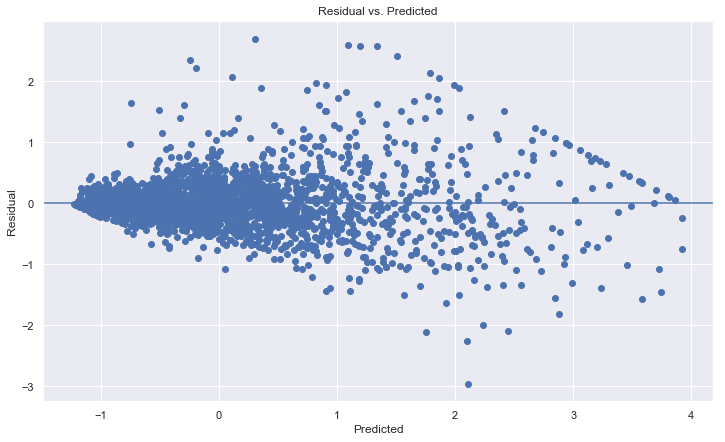

In [26]:
model(ensemble.RandomForestRegressor(), X, Y)

The residual plot appears to do well expect that very high/low values are not predicted very well with this model.

### Gradient Boost Regression

Model R-squared score is 0.88

Accuracy by Cross_validation: 0.83 (+/- 0.03)

The Root Mean Squared Error is 0.40


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

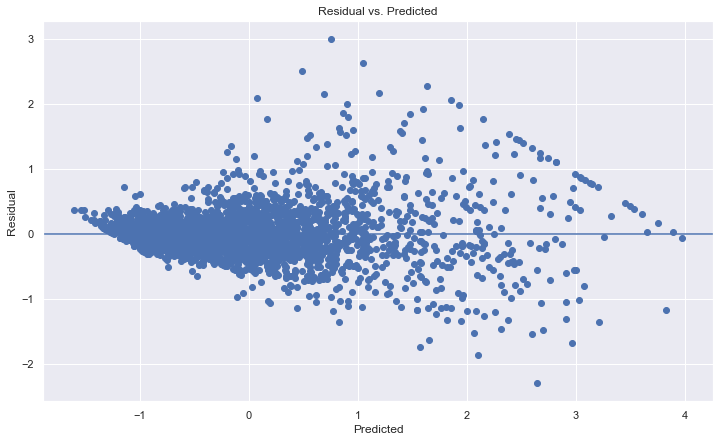

In [27]:
params = {'n_estimators': 500,
          'max_depth': 2}
model(ensemble.GradientBoostingRegressor(**params), X, Y)

Model R-squared score is 0.88

Accuracy by Cross_validation: 0.83 (+/- 0.03)

The Root Mean Squared Error is 0.40


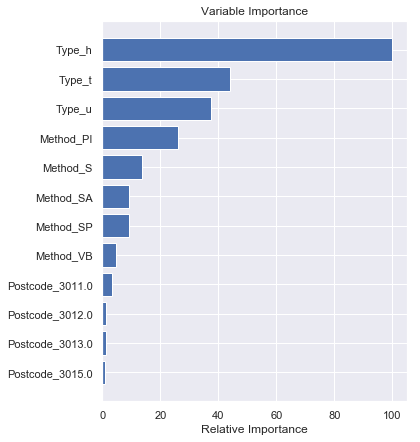

In [28]:
mo=model(ensemble.GradientBoostingRegressor(**params), X, Y)
feature_importance = mo.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
fea_imp=np.array(sorted(list(feature_importance), reverse=True)[0:12])
sorted_idx = np.argsort(fea_imp)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, fea_imp[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

As suggested by the Gradient boost model above are the top 12 features needed for a real estate developer to add value to a house and also predictive of the prices of house.

The Gradient Boost model has the highest accuracy of 84% in all SUpervised models.

Now let us see if we can increase it even further by using Unsupervised learning models or Neural Networks namely MLP.

Model R-squared score is 0.99

Accuracy by Cross_validation: 0.81 (+/- 0.03)

The Root Mean Squared Error is 0.41


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

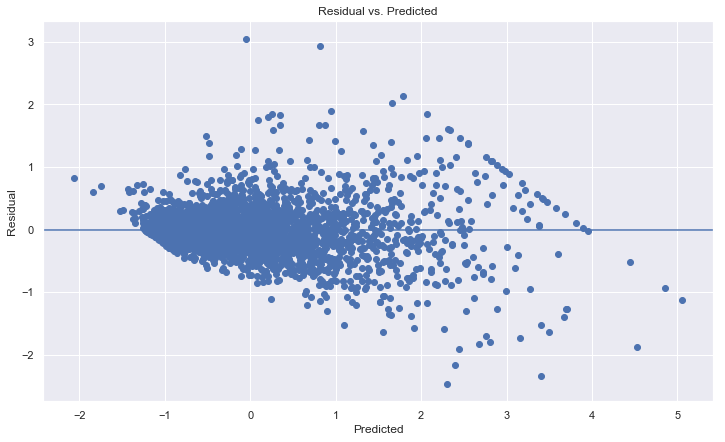

In [29]:
# Establish and fit the model, with a single, 1000 perceptron layer.
model(MLPRegressor(hidden_layer_sizes=(1000, )), X, Y)

The model R2 squared was much higher than other supervised models but the crossvalidation score was similar to Random Forest and Gradient Boost algorithms.

Model R-squared score is 1.00

Accuracy by Cross_validation: 0.80 (+/- 0.03)

The Root Mean Squared Error is 0.40


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

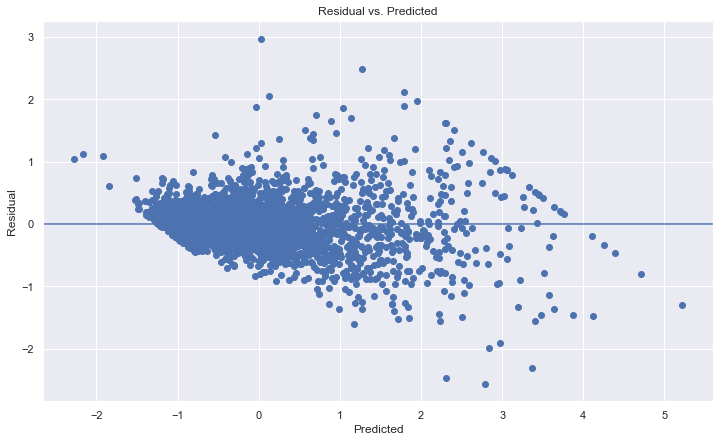

In [30]:
# Adding solver as lbfgs since it converges faster with small datasets compared to adam
model(MLPRegressor(hidden_layer_sizes=(1000, ), solver='lbfgs'), X, Y)

Model R-squared score is 0.81

Accuracy by Cross_validation: 0.76 (+/- 0.04)

The Root Mean Squared Error is 0.47


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

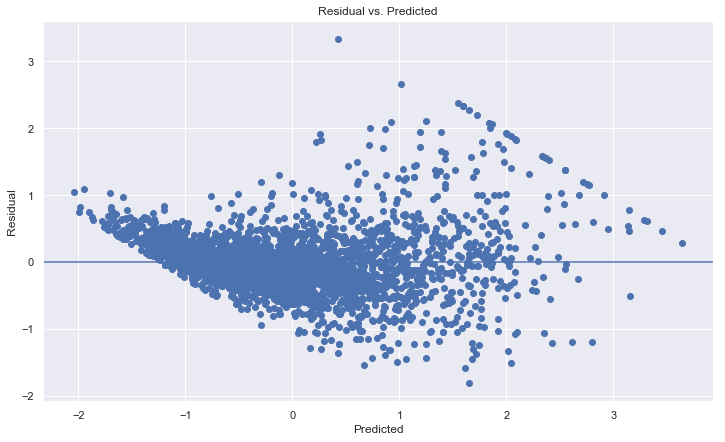

In [31]:
# Just making sure we are using the right activator function.
# We need to use relu as the function for regression and probably logistic ckassification 
model(MLPRegressor(hidden_layer_sizes=(1000, ), solver='lbfgs', activation='logistic'), X, Y)

Logistic decreased the accuracy and other results and so not going to use it from now on.

Model R-squared score is 0.99

Accuracy by Cross_validation: 0.80 (+/- 0.03)

The Root Mean Squared Error is 0.41


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

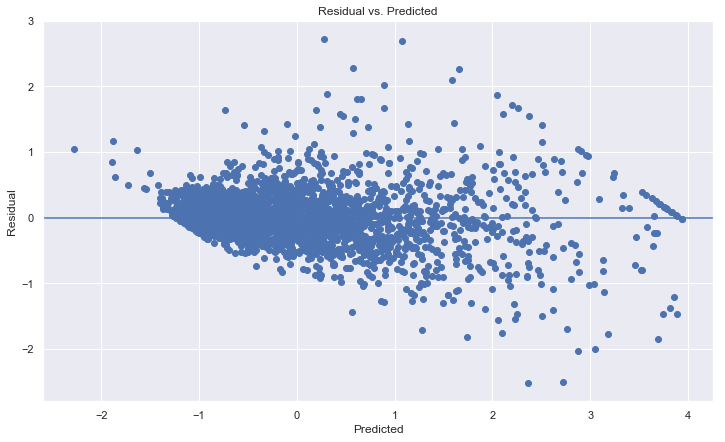

In [32]:
# Adding more layers (2 Layers) since from previous assignment experience I see that adding layers 
#decreases gap between model score and crossvalidation score.
model(MLPRegressor(hidden_layer_sizes=(1000, 4), solver='lbfgs'), X, Y)

More or less, no change with the results

Model R-squared score is 0.97

Accuracy by Cross_validation: 0.84 (+/- 0.03)

The Root Mean Squared Error is 0.38


MLPRegressor(activation='relu', alpha=10, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

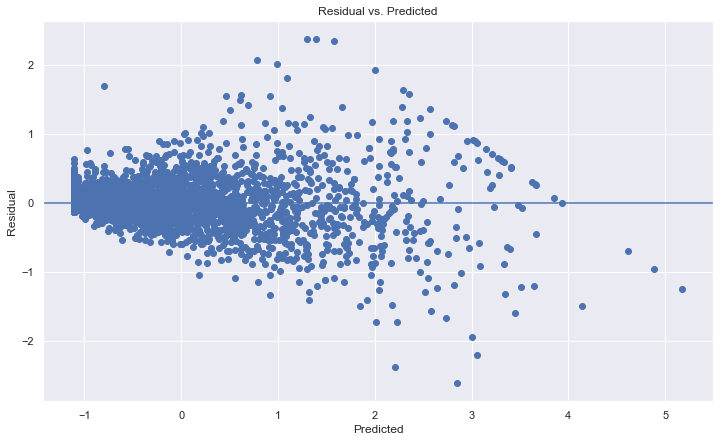

In [33]:
# Chaning the alpha to higher value..i.e more penalty from default value of 0.0001
model(MLPRegressor(hidden_layer_sizes=(1000, 4), solver='lbfgs', alpha = 10), X, Y)

chaning alpha to higher penalty made the accuracy and error better but not by too much. It is still better to have little higher accuracy and lower error.

Tried more than 10 but causes the accuracy to go down.

So In conlusion the Neural network supposed to be superior than all other models...in this particular case did not perform to that extent with increase by 1% in accuracy compared to supervised models.

It think the tradeoff of letting go on the complexity is not worth it because the accuracy did not increase that well in this particular case or dataset.